# 04 Baseline Model

In [8]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import boto3
import sagemaker
from pyathena import connect
import matplotlib.pyplot as plt


In [2]:
%store

Stored variables and their in-db values:
account_id                               -> '607916531205'
create_base_csv_athena_db                -> True
create_base_csv_athena_table             -> True
database_name                            -> 'db_airline_delay_cause'
dev_feature_group_name                   -> 'airline_delay_features_dev'
dev_feature_store_table                  -> 'airline_delay_features_dev_1739840246'
dev_s3_path                              -> 's3://sagemaker-us-east-1-607916531205/data/develo
dev_s3_uri                               -> 's3://sagemaker-us-east-1-607916531205/feature-sto
dev_table_name                           -> 'development_data'
packages_installed                       -> True
prod_feature_group_name                  -> 'airline_delay_features_prod'
prod_feature_store_table                 -> 'airline_delay_features_prod_1739840413'
prod_s3_path                             -> 's3://sagemaker-us-east-1-607916531205/data/produc
prod_s3_uri         

# Query Values from Development Database

In [3]:
# ✅ Retrieve stored variables
%store -r database_name
%store -r dev_table_name
%store -r s3_staging_dir

# Define file path
csv_path = "development_data.csv"

# Check if CSV file exists
if os.path.exists(csv_path):
    print("Loading data from local CSV...")
    df = pd.read_csv(csv_path)
else:
    print("CSV not found! Querying from Athena...")
    
    # Athena connection
    conn = connect(s3_staging_dir=s3_staging_dir, region_name="us-east-1")
    
    # Query development dataset
    query = f"SELECT * FROM {database_name}.{dev_table_name};"
    df = pd.read_sql(query, conn)
    
    # Save locally for future use
    df.to_csv(csv_path, index=False)
    print(f"Data saved locally as {csv_path}")

# Define feature columns and target variable
features = [
    "arr_flights", "arr_del15", "carrier_ct", "weather_ct", "nas_ct", 
    "security_ct", "late_aircraft_ct", "arr_cancelled", "arr_diverted", 
    "arr_delay", "carrier_delay", "weather_delay", "nas_delay", 
    "security_delay", "late_aircraft_delay", "delay_rate"
]
target = "on_time"

# Ensure no missing values
df = df.dropna()

Loading data from local CSV...


# Create Linear Regression Baseline Model

In [10]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Initialize and train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_train_pred = model.predict(X_train)  # FIX: Add predictions for training set
y_test_pred = model.predict(X_test)    # FIX: Use correct variable name



# Evaluate Model Performance

In [11]:
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")



Mean Squared Error: 0.0137
R² Score: 0.0688


# Visualization

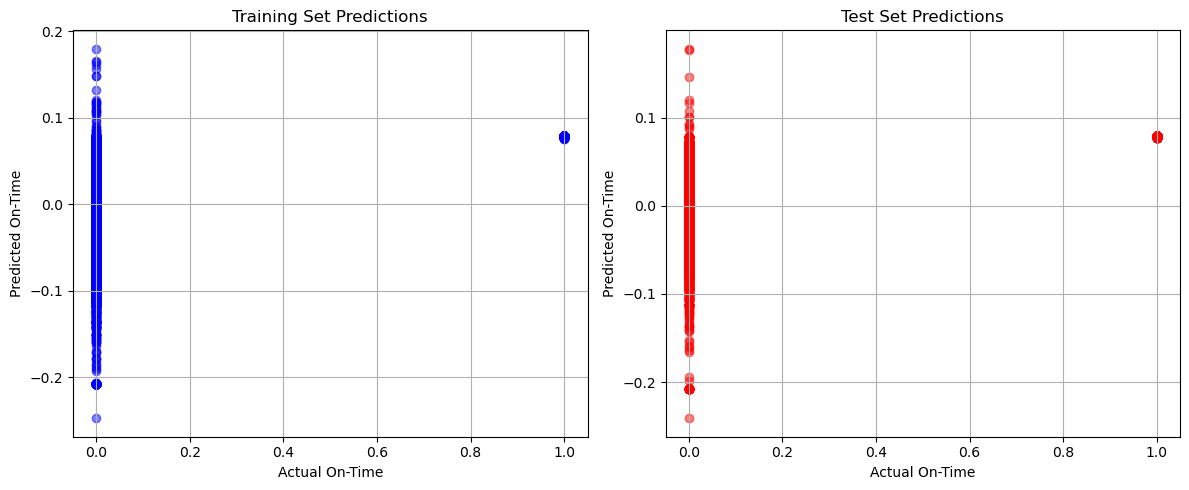

In [12]:
# Visualization
plt.figure(figsize=(12,5))

# Training Set
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5, color='blue')
plt.xlabel("Actual On-Time")
plt.ylabel("Predicted On-Time")
plt.title("Training Set Predictions")
plt.grid()

# Test Set
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5, color='red')
plt.xlabel("Actual On-Time")
plt.ylabel("Predicted On-Time")
plt.title("Test Set Predictions")
plt.grid()

plt.tight_layout()
plt.show()

# Store Model

In [19]:
# Save the model for future use
baseline_model_path = "baseline_model.pkl"
joblib.dump(model, baseline_model_path)
print(f"Model saved as {baseline_model_path}")
%store baseline_model_path

Model saved as baseline_model.pkl
Stored 'baseline_model_path' (str)


# Try Logistic Regression + Scaling Instead

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Make predictions (use probabilities for better interpretation)
y_train_pred_prob = model.predict_proba(X_train_scaled)[:, 1]
y_test_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

# Convert probabilities to binary (0 or 1) based on a 0.5 threshold
y_train_pred = (y_train_pred_prob >= 0.5).astype(int)
y_test_pred = (y_test_pred_prob >= 0.5).astype(int)


✅ Training Accuracy: 0.9989
✅ Testing Accuracy: 0.9988

Confusion Matrix (Test Set):
[[25706    32]
 [    0   391]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25738
           1       0.92      1.00      0.96       391

    accuracy                           1.00     26129
   macro avg       0.96      1.00      0.98     26129
weighted avg       1.00      1.00      1.00     26129



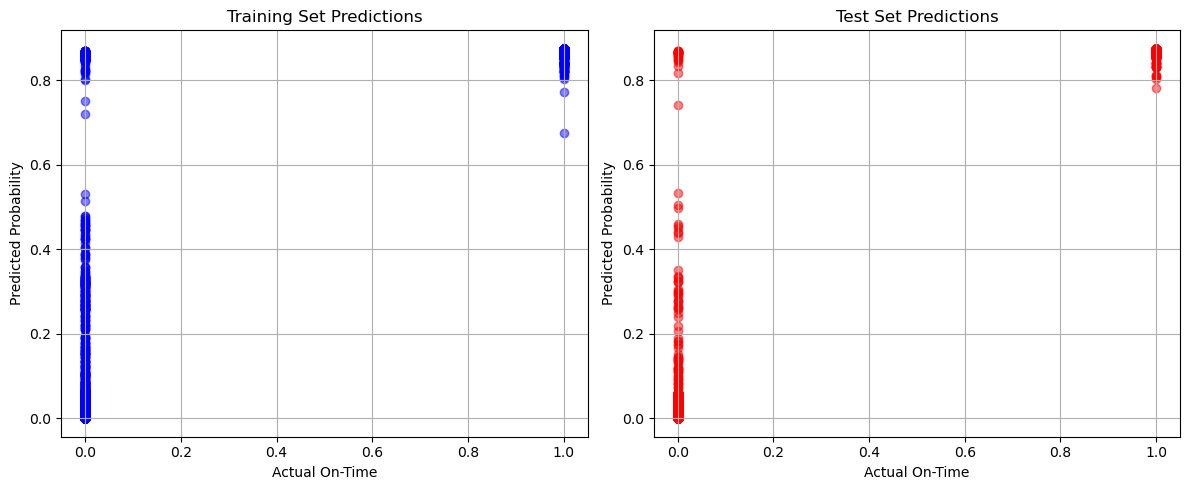

In [15]:
# Model Evaluation
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"✅ Training Accuracy: {train_accuracy:.4f}")
print(f"✅ Testing Accuracy: {test_accuracy:.4f}")

# Confusion Matrix
print("\nConfusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_test_pred))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Visualization
plt.figure(figsize=(12,5))

# Training Set Predictions
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred_prob, alpha=0.5, color='blue')
plt.xlabel("Actual On-Time")
plt.ylabel("Predicted Probability")
plt.title("Training Set Predictions")
plt.grid()

# Test Set Predictions
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_prob, alpha=0.5, color='red')
plt.xlabel("Actual On-Time")
plt.ylabel("Predicted Probability")
plt.title("Test Set Predictions")
plt.grid()

plt.tight_layout()
plt.show()

In [20]:
# Save the model for future use
baseline_model_logistic_path = "baseline_model_logistic.pkl"
joblib.dump(model, baseline_model_logistic_path)
print(f"Model saved as {baseline_model_logistic_path}")
%store baseline_model_logistic_path

Model saved as baseline_model_logistic.pkl
Stored 'baseline_model_logistic_path' (str)
